### 1. Load data and import packages

In [1]:
import pandas as pd
import numpy as np

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

data = pd.read_csv("data.csv")
data_imp_mice = pd.read_csv("data_imp_mice.csv")

In [2]:
labels = list(data_imp_mice.columns.values)
labels.remove('expire_flag')
labels.append('expire_flag')
data_imp_mice = data_imp_mice[labels]
labels.remove('expire_flag')
shape = data_imp_mice.shape
print("Instances (Patients): " + str(shape[0]) + ", Features: " + str(shape[1]-1))

Instances (Patients): 3960, Features: 49


### 2. Shuffle and Preprocessing

In [3]:
def shuffledata(dataframe):
    from sklearn.utils import shuffle
    #dataframe = dataframe.copy().sample(frac=1) 
    dataframe = dataframe.copy().sample(frac=1,random_state=69)    
    return dataframe

def scaledata(dataframe):
    from sklearn import preprocessing
    scaler = preprocessing.MinMaxScaler()
    labels = (dataframe.columns.values)
    scaler.fit(dataframe)
    dataframe[labels] = scaler.transform(dataframe[labels])
    return dataframe

def crossval(df,model,folds=4):
    from sklearn.metrics import accuracy_score
    from sklearn.model_selection import cross_val_score, KFold
    scores_train = [];
    scores_test = [];
    X = df.drop("expire_flag",axis=1).reset_index(drop=True)
    Y = df["expire_flag"].reset_index(drop=True)
    X = scaledata(X)
    crossval = KFold(n_splits=folds);        
    for train_index, test_index in crossval.split(X):
        # Segregate
        Xtrain, Xtest, Ytrain, Ytest = X.iloc[train_index,:], X.iloc[test_index,:], Y[train_index], Y[test_index]
        # Training Model
        model.fit(Xtrain,Ytrain)
        Ytrain_pred = model.predict(Xtrain)
        Ytest_pred = model.predict(Xtest)
        scores_train.append(100*accuracy_score(Ytrain,Ytrain_pred))
        scores_test.append(100*accuracy_score(Ytest,Ytest_pred))
    return scores_train, scores_test

def returnCVscore(df,model,iter=10,folds=4):
    train_acc = []
    test_acc = []   
    for i in range(iter):
        df = shuffledata(df)
        train_temp, test_temp = crossval(df,model,folds)
        train_acc.append(np.mean(train_temp))
        test_acc.append(np.mean(test_temp))
    print("Training Accuracy: " + "%.4f" %(np.mean(train_acc)) + "%, Test Accuracy: " + "%.4f" %(np.mean(test_acc)) + "%")
    return np.mean(train_acc), np.mean(test_acc)

In [4]:
#df = data_imp_mean
df = shuffledata(data_imp_mice)
X = df[labels]
Y = df.iloc[:,-1]

crossval = KFold(n_splits=4);        
for train_index, test_index in crossval.split(X):
    Xtrain, Xtest, Ytrain, Ytest = X.iloc[train_index,:], X.iloc[test_index,:], Y.iloc[train_index], Y.iloc[test_index]

In [5]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
scaler.fit(Xtrain)
Xtrain[labels] = scaler.transform(Xtrain[labels])
Xtest[labels] = scaler.transform(Xtest[labels])

C:\Users\Ming\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Ming\Anaconda3\lib\site-packages\pandas\core\frame.py:3395: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\Ming\Anaconda3\lib\site-packages\pandas\core\frame.py:3367: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

### 3. Build Models

In [6]:
# 1. Logistic Regression
from sklearn.linear_model import LogisticRegression    
LogReg = LogisticRegression(solver='lbfgs',multi_class='ovr',max_iter=1000000)
# 2. Random Forest
rf_params = [1000,3,5]
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=rf_params[0],min_samples_leaf=rf_params[1],max_depth=rf_params[2],criterion='entropy')
# 3. XGBoost
xgb_params = [0.02,300,5,7]
from xgboost.sklearn import XGBClassifier
XGBoost = XGBClassifier(learning_rate=xgb_params[0],n_estimators=xgb_params[1],max_depth=xgb_params[2],min_child_weight=xgb_params[3])
# 4. SVM-G
from sklearn.svm import SVC
SVM = SVC(gamma='scale',probability=True)
# 4. kNN
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=15)
# 5. Multilayer Perceptron
from sklearn.neural_network import MLPClassifier
MLP = MLPClassifier(hidden_layer_sizes=(50,20), max_iter=1000, alpha=0.05, solver='adam', verbose=None, tol=0.00001)

In [7]:
LogReg.fit(Xtrain,Ytrain)
RF.fit(Xtrain,Ytrain)
XGBoost.fit(Xtrain.values,Ytrain.values)#SVM.fit(Xtrain,Ytrain)
MLP.fit(Xtrain,Ytrain)

from sklearn.metrics import accuracy_score
print("Logistic Regression | Training Accuracy: " + "%.2f" %(accuracy_score(Ytrain, LogReg.predict(Xtrain))*100) + "%, Test Accuracy: " + "%.2f" %(accuracy_score(Ytest, LogReg.predict(Xtest))*100) + "%")
print("Random Forest | Training Accuracy: " + "%.2f" %(accuracy_score(Ytrain, RF.predict(Xtrain))*100) + "%, Test Accuracy: " + "%.2f" %(accuracy_score(Ytest, RF.predict(Xtest))*100) + "%")
print("XGBoost | Training Accuracy: " + "%.2f" %(accuracy_score(Ytrain.values, XGBoost.predict(Xtrain.values))*100) + "%, Test Accuracy: " + "%.2f" %(accuracy_score(Ytest.values, XGBoost.predict(Xtest.values))*100) + "%")
#print("SVM | Training Accuracy: " + "%.2f" %(accuracy_score(Ytrain, SVM.predict(Xtrain))*100) + "%, Test Accuracy: " + "%.2f" %(accuracy_score(Ytest, SVM.predict(Xtest))*100) + "%")
print("MLP | Training Accuracy: " + "%.2f" %(accuracy_score(Ytrain, MLP.predict(Xtrain))*100) + "%, Test Accuracy: " + "%.2f" %(accuracy_score(Ytest, MLP.predict(Xtest))*100) + "%")

Logistic Regression | Training Accuracy: 77.58%, Test Accuracy: 76.36%
Random Forest | Training Accuracy: 81.65%, Test Accuracy: 79.29%
XGBoost | Training Accuracy: 88.62%, Test Accuracy: 80.10%
MLP | Training Accuracy: 85.56%, Test Accuracy: 77.07%


### 4. Explainability

### Test explanations

In [8]:
# Obtain index from Training Set
index = 0
df_index = Xtrain.iloc[index:index+1,:].index.tolist()[0]
print(df_index)
#index_test Obtain index from Test Set
index_test = 7
df_index_test = Xtest.iloc[index_test:index_test+1,:].index.tolist()[0]
print(df_index_test)

55
2863


In [9]:
print(LogReg.predict_proba(Xtest.iloc[index_test:index_test+1,:]))
print(RF.predict_proba(Xtest.iloc[index_test:index_test+1,:]))
print(XGBoost.predict_proba(Xtest.iloc[index_test:index_test+1,:].values))
print(MLP.predict_proba(Xtest.iloc[index_test:index_test+1,:]))

[[0.20957624 0.79042376]]
[[0.31223018 0.68776982]]
[[0.22832042 0.7716796 ]]
[[0.09660688 0.90339312]]


In [10]:
data_imp_mice.iloc[df_index_test:df_index_test+1,:]
Xtest.iloc[index_test:index_test+1,:]

,gender,admit_no,age,Glucose,Creatinine,Urea Nitrogen,Potassium,Hematocrit,Hemoglobin,Platelet Count,...,"Hematocrit, Calculated",Calcium Gluconate,Oxygen Saturation,"Sodium, Whole Blood",Aspirin EC,SPECIMEN TYPE,Nitroglycerin,Extracorporeal circulation auxiliary to open heart surgery,Specific Gravity,Iso-Osmotic Dextrose
2863,1.0,0.0,1.0,0.110651,0.065657,0.234848,0.278689,0.389016,0.299363,0.492898,...,0.452098,0.029583,0.237591,0.507858,0.045229,0.141162,0.435265,0.87475,0.942777,0.965179


### SHAP

In [11]:
import shap
shap.initjs()
import lime
from treeinterpreter import treeinterpreter as ti

### SHAP and STV Functions

In [12]:
def rankshapfinal(shap_values, winners = 3):
    rank_average = np.mean(shap_values,axis=0)

    import py3votecore
    from py3votecore.stv import STV
    from py3votecore.condorcet import CondorcetHelper
    
    ballot_dictionary = []
    for i in range(shap_values.shape[0]):
        
        # Take absolute rankings
        sort = shap_values[i,:]

        # Initialise 'count' and 'ballot' sections
        ballot_temp = {}        
        ballot_temp['count'] = 1
        ballot_temp['ballot'] = sort.tolist()
        ballot_dictionary.append(ballot_temp)         
    rank_STV = STV(ballot_dictionary, required_winners=winners).as_dict()    
    return rank_average, rank_STV
def returnrankedSTV(exp_array,winners=15):
    rank_LR_STV_ordered = []
    for i in range(winners):
         for j in rankshapfinal(np.argsort(-exp_array,axis=1), winners=i)[1]['winners']:
            if (len(rank_LR_STV_ordered)< winners) & (j not in rank_LR_STV_ordered):
                rank_LR_STV_ordered.append(j)
    return rank_LR_STV_ordered
def returnrankedSTVshare(exp_array,winlist):
    list = []
    for i in winlist:
        list.append(np.mean(np.abs(exp_array[:,i])))
    return list

In [13]:
# Get percentage values for a single instance
def getshapsinstance(shap_values):
    return shap_values/np.sum(np.abs(shap_values))
def lime_to_array(exp):
    test = exp.as_list()
    test_array = np.zeros((49,))
    for j in range(49):
        for i in range(49):
            if labels[i] + " " in test[j][0]:
                test_array[i] = test[j][1]
    return test_array
def rankshapvalues(shap_values, winners = 3):
    rank_average = np.mean(shap_values,axis=0)

    import py3votecore
    from py3votecore.stv import STV
    from py3votecore.condorcet import CondorcetHelper
    
    ballot_dictionary = []
    for i in range(shap_values.shape[0]):
        
        # Take absolute rankings
        temp = shap_values[i,:]
        sort = np.argsort(-temp)

        # Initialise 'count' and 'ballot' sections
        ballot_temp = {}        
        ballot_temp['count'] = 1
        ballot_temp['ballot'] = sort.tolist()
        ballot_dictionary.append(ballot_temp)         
    rank_STV = STV(ballot_dictionary, required_winners=winners).as_dict()    
    return rank_average, rank_STV

def order(rank_dictionary):
    test = []
    for i in range(len(rank_dictionary['rounds'])):
        try:
            temp = rank_dictionary['rounds'][i]['winners']
            test.append(temp)
        except:
            quit
    return test

In [14]:
import warnings
warnings.filterwarnings("ignore")

### Obtain explanations for all

In [15]:
idx = index_test
print(idx)

7


#### 1. Logistic Regression

In [17]:
# Using LinearSHAP
LR_SHAP = shap.KernelExplainer(LogReg.predict_proba, shap.kmeans(Xtrain,5))
exp_LR_SHAP = LR_SHAP.shap_values(Xtest)[1]
# Using coefficients
exp_LR_coef = LogReg.coef_
# Using LIME
LR_LIME = lime.lime_tabular.LimeTabularExplainer(Xtrain.to_numpy(), feature_names=labels, class_names=[0,1], discretize_continuous=True)

HBox(children=(IntProgress(value=0, max=990), HTML(value='')))

In [18]:
LR_exp = np.zeros((3,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
LR_exp[0,:] = getshapsinstance(exp_LR_SHAP[idx,:])
# ROW 1: COEFFICIENTS
LR_exp[1,:] = getshapsinstance(exp_LR_coef)
# ROW 2: LIME
LR_exp[2,:] = getshapsinstance(lime_to_array(LR_LIME.explain_instance(Xtest.to_numpy()[idx,:], LogReg.predict_proba, num_features=49)))

In [19]:
print("1. Selecting local explanation values for each method")
print("Logistic Regression, SHAP values")
print(np.argsort(-LR_exp[0,:]))
print("Logistic Regression, coefficients")
print(np.argsort(-LR_exp[1,:]))
print("Logistic Regression, LIME")
print(np.argsort(-LR_exp[2,:]))

1. Selecting local explanation values for each method
Logistic Regression, SHAP values
[ 2 17  5 35 30 29 32 28 45 19 26 33 34  0 27 38 39 40 41 42 43 44 46 36
 37 24 47  1  3  4  6  7  8  9 10 11 25 12 14 15 18 20 21 22 13 48 23 31
 16]
Logistic Regression, coefficients
[ 2 17  5 19 31 33 12  1 46 15 45 23 35 28 11 10 44 21 43 22  6 48 18 37
 42  9  0 47 36 13 24  7 38 41  4  8 32 14 25 29  3 20 34 40 27 26 30 39
 16]
Logistic Regression, LIME
[ 2 17  5 45 34 16 28 30 19 32 26 29 38 25 42 13 33 10 46 41  8 48 40 47
 20  7  6  3 14 22 12 44 24 37 35 43 36  9  4 11 15 18 21  0 39 27 23  1
 31]


In [20]:
print("STV Aggregation of Logistic Regression Explanations")
rank_LR_STV_all = returnrankedSTV(LR_exp,15)
print(rank_LR_STV_all)
rank_LR_STV_avg = returnrankedSTVshare(LR_exp,rank_LR_STV_all)
print(rank_LR_STV_avg)

STV Aggregation of Logistic Regression Explanations
[2, 17, 5, 35, 45, 19, 34, 30, 31, 33, 16, 29, 32, 28]
[0.20794966290475334, 0.17460435956146428, 0.08319340281403058, 0.03173171685461478, 0.02645657265375233, 0.025494569552200294, 0.0158770225394976, 0.029723553179364925, 0.044908631362276685, 0.015206416179632943, 0.04427361300580029, 0.01985306809186114, 0.01826046237942082, 0.020952567650176418]


In [21]:
shap.force_plot(LR_SHAP.expected_value[1], exp_LR_SHAP[index_test,:], data_imp_mice.iloc[df_index_test,:49], feature_names=labels)

#### 2. Random Forest

In [22]:
RF_SHAP = shap.TreeExplainer(RF)
exp_RF_SHAP = RF_SHAP.shap_values(Xtest)[1]
exp_RF_coef = ti.predict(RF,Xtest)[2][:,:,1]
RF_LIME = lime.lime_tabular.LimeTabularExplainer(Xtrain.to_numpy(), feature_names=labels, class_names=[0,1], discretize_continuous=True)

RF_exp = np.zeros((3,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
RF_exp[0,:] = getshapsinstance(exp_RF_SHAP[idx,:])
# ROW 1: COEFFICIENTS
RF_exp[1,:] = getshapsinstance(exp_RF_coef[idx,:])
# ROW 2: LIME
RF_exp[2,:] = getshapsinstance(lime_to_array(RF_LIME.explain_instance(Xtest.to_numpy()[idx,:], RF.predict_proba, num_features=49)))

In [23]:
print("1. Selecting local explanation values for each method")
print("RF, SHAP values")
print(np.argsort(-RF_exp[0,:]))
print("RF, coefficients")
print(np.argsort(-RF_exp[1,:]))
print("RF, LIME")
print(np.argsort(-RF_exp[2,:]))

1. Selecting local explanation values for each method
RF, SHAP values
[17  5  2 43 46 30 40 33 35  4 28 45 41 29 14  8 36 32 18 13  7 37  9 24
 26 11 20  0  1 19 42  3 10 38  6 25 15 16 48 34 12 39 31 47 23 22 21 44
 27]
RF, coefficients
[17  5  2 30 46 43 33  4 40 35 28 45 41 14 36  8 29  7 13 11  9 32 26 37
 24 19  3  1 20  0 42  6 10 25 48 18 38 16 15 34 12 39 23 31 47 21 22 44
 27]
RF, LIME
[17  5  2 46  4 43 30 35 28 33 40 45 14 29 19 36 13  8 18  9 41  0 37 32
 26  1 31 20 38 10 24  6  7 23 47 11  3 15 42 12 48 25 16 44 21 39 22 34
 27]


In [24]:
rank_RF_avg, rank_RF_STV = rankshapvalues(RF_exp,winners=15)
print("STV Aggregation of Random Forest Explanations")
print(rankshapfinal(np.argsort(-RF_exp,axis=1), winners=15)[1]['winners'])

STV Aggregation of Random Forest Explanations
{33, 2, 35, 4, 5, 40, 41, 43, 45, 46, 14, 17, 28, 29, 30}


In [25]:
print("STV Aggregation of Logistic Regression Explanations")
rank_RF_STV_all = returnrankedSTV(RF_exp,15)
print(rank_RF_STV_all)
rank_RF_STV_avg = returnrankedSTVshare(RF_exp,rank_RF_STV_all)
print(rank_RF_STV_avg)

STV Aggregation of Logistic Regression Explanations
[17, 5, 2, 43, 30, 46, 33, 4, 40, 35, 28, 45, 41, 14]
[0.1813647696655075, 0.15948817406867344, 0.12186127802245313, 0.05117857737955292, 0.04835711315237984, 0.05094255138235684, 0.03736441754060633, 0.03777682023008754, 0.03227409309287826, 0.03400646962182153, 0.026875709549935362, 0.02171103065440122, 0.011582830227527591, 0.012134795446784238]


In [26]:
shap.force_plot(RF_SHAP.expected_value[1], exp_RF_SHAP[index_test,:], data_imp_mice.iloc[df_index_test,:49], feature_names=labels)

#### 3. XGBoost

In [27]:
XGB_SHAP = shap.TreeExplainer(XGBoost,data = Xtrain.values, model_output = "probability")
exp_XGB_SHAP = XGB_SHAP.shap_values(Xtest.iloc[0:10,:].values)

In [28]:
XGB_SHAP = shap.TreeExplainer(XGBoost,data = Xtrain, model_output = "probability")
exp_XGB_SHAP = XGB_SHAP.shap_values(Xtest)
XGB_LIME = lime.lime_tabular.LimeTabularExplainer(Xtrain.to_numpy(), feature_names=labels, class_names=[0,1], discretize_continuous=True)

XGB_exp = np.zeros((2,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
XGB_exp[0,:] = getshapsinstance(exp_XGB_SHAP[idx,:])
# ROW 1: LIME
XGB_exp[1,:] = getshapsinstance(lime_to_array(XGB_LIME.explain_instance(Xtest.to_numpy()[idx,:], XGBoost.predict_proba, num_features=49)))

100%|===================| 987/990 [07:20<00:01]        

In [29]:
XGB_exp = np.zeros((2,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
XGB_exp[0,:] = getshapsinstance(exp_XGB_SHAP[idx,:])
# ROW 1: LIME
XGB_exp[1,:] = getshapsinstance(lime_to_array(XGB_LIME.explain_instance(Xtest.to_numpy()[idx,:], XGBoost.predict_proba, num_features=49)))

In [30]:
print("1. Selecting local explanation values for each method")
print("XGBoost, SHAP values")
print(np.argsort(-XGB_exp[0,:]))
print("XGBoost, LIME")
print(np.argsort(-XGB_exp[1,:]))

1. Selecting local explanation values for each method
XGBoost, SHAP values
[ 2 17  5 40 43 46 33 29 36  9 45 28 14 35 30  7 41 32 20 26 25  8  3 13
  4 22 11 24  0 18  1 34 38 21 10 47 15 19  6 37 12 39 42 48 16 27 31 23
 44]
XGBoost, LIME
[ 2 17  5 46 43 40 35 33 29 28 45  7 30 44 36 14  1 12 24 21  8 41  9 23
 38 22 48  0 25 20 34 26 37 15  3 11 32 31 47 13  4 10 19  6 18 27 39 16
 42]


In [31]:
print("STV Aggregation of Logistic Regression Explanations")
rank_XGB_STV_all = returnrankedSTV(XGB_exp,15)
print(rank_XGB_STV_all)
rank_XGB_STV_avg = returnrankedSTVshare(XGB_exp,rank_XGB_STV_all)
print(rank_XGB_STV_avg)

STV Aggregation of Logistic Regression Explanations
[2, 17, 5, 46, 40, 28, 43, 15, 36, 14, 47, 3, 16, 21, 27]
[0.17318775701964784, 0.14235680504268483, 0.11262974788917793, 0.05085147075426899, 0.050959168032943106, 0.02159916949293153, 0.05089603309035022, 0.0019998762953798996, 0.0168452065585981, 0.01208104996422421, 0.004141302897886461, 0.0028671258597598175, 0.016790741558592257, 0.0025291034432676674, 0.01520577056069381]


In [32]:
shap.force_plot(XGB_SHAP.expected_value, exp_XGB_SHAP[index_test,:], data_imp_mice.iloc[df_index_test,:49], feature_names=labels)

#### 4. MLP

In [33]:
MLP_SHAP = shap.KernelExplainer(MLP.predict_proba, shap.kmeans(Xtrain,5))
exp_MLP_SHAP = MLP_SHAP.shap_values(Xtest)[1]
MLP_LIME = lime.lime_tabular.LimeTabularExplainer(Xtrain.to_numpy(), feature_names=labels, class_names=[0,1], discretize_continuous=True)
# Explanations for 0
idx = 0
MLP_exp = np.zeros((2,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
MLP_exp[0,:] = getshapsinstance(exp_MLP_SHAP[idx,:])
# ROW 1: LIME
MLP_exp[1,:] = getshapsinstance(lime_to_array(MLP_LIME.explain_instance(Xtest.to_numpy()[idx,:], MLP.predict_proba, num_features=49)))

HBox(children=(IntProgress(value=0, max=990), HTML(value='')))

In [34]:
print("1. Selecting local explanation values for each method")
print("MLP, SHAP values")
print(np.argsort(-MLP_exp[0,:]))
print("MLP, LIME")
print(np.argsort(-MLP_exp[1,:]))

1. Selecting local explanation values for each method
MLP, SHAP values
[ 5 32 33 39  2 30 41 16 11 42  9 29  4  3 28 45 22  6 15 46  1 40  7 36
 34  8 14 48 26 19 21 47 27 20 18 38 17 13 43 12 37 10 35 44 23 25 24 31
  0]
MLP, LIME
[ 5 33 11  2  9 30 28 16 32 29 41 24 19 15  3 22 18  4 48 42 39 14 47 45
 26  6 17 36 20 27 46 44 13  8  7 25 23 21 43 35 38  0 31 37 10 12 40 34
  1]


In [35]:
print("STV Aggregation of Logistic Regression Explanations")
rank_MLP_STV_all = returnrankedSTV(MLP_exp,15)
print(rank_MLP_STV_all)
rank_MLP_STV_avg = returnrankedSTVshare(MLP_exp,rank_MLP_STV_all)
print(rank_MLP_STV_avg)

STV Aggregation of Logistic Regression Explanations
[5, 32, 33, 38, 43, 31, 2, 34, 47, 22, 40, 13, 46, 36, 44]
[0.1005614009667476, 0.055190237090654015, 0.06463033530820736, 0.014381510074100051, 0.02063280740967988, 0.039822704613945464, 0.0367939561962112, 0.017463149926405727, 0.0007223186743227154, 0.006752632509568994, 0.013698460248970262, 0.009471789735346445, 0.004489184304892334, 0.002759651226167884, 0.019726949529547493]


In [36]:
shap.force_plot(MLP_SHAP.expected_value[1], exp_MLP_SHAP[index_test,:], data_imp_mice.iloc[df_index_test,:49], feature_names=labels)

### Patient-Specific Aggregation

In [41]:
returnrankedSTV(np.concatenate([LR_exp,RF_exp,XGB_exp,MLP_exp]),11)

[2, 17, 5, 33, 45, 46, 19, 35, 40, 30, 43]

In [46]:
print("STV Aggregation Across all explanation methods")
rank_all_STV = returnrankedSTV(np.concatenate([LR_exp,RF_exp,XGB_exp,MLP_exp]),11)
print(rank_all_STV)
rank_all_STV_avg = returnrankedSTVshare(np.concatenate([LR_exp,RF_exp,XGB_exp,MLP_exp]),rank_all_STV)
print(rank_all_STV_avg)
for i in range(10):
    print(str(i),labels[rank_all_STV[i]],rank_all_STV_avg[i])

STV Aggregation Across all explanation methods
[2, 17, 5, 33, 19, 46, 40, 45, 35, 43, 30]
[0.14093962492133372, 0.13637518242703892, 0.11544270283599631, 0.03654886013710558, 0.010929836910862387, 0.02980503069971575, 0.024801361531689804, 0.01889992496320329, 0.03070180643573121, 0.031244995322608334, 0.032908510648367625]
0 age 0.14093962492133372
1 RDW 0.13637518242703892
2 Urea Nitrogen 0.11544270283599631
3 Furosemide 0.03654886013710558
4 Anion Gap 0.010929836910862387
5 Extracorporeal circulation auxiliary to open heart surgery 0.02980503069971575
6 Calcium Gluconate 0.024801361531689804
7 Nitroglycerin 0.01889992496320329
8 Aspirin 0.03070180643573121
9 Aspirin EC 0.031244995322608334


In [47]:
for i in rank_all_STV:
    print(labels[i])

age
RDW
Urea Nitrogen
Furosemide
Anion Gap
Extracorporeal circulation auxiliary to open heart surgery
Calcium Gluconate
Nitroglycerin
Aspirin
Aspirin EC
pO2


### Overall Aggregation

In [ ]:
## Getting aggregated features

LR_exp_ovr = np.zeros((3,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
LR_exp_ovr[0,:] = getshapsinstance(np.mean(np.abs(exp_LR_SHAP),axis=0))
# ROW 1: COEFFICIENTS
LR_exp_ovr[1,:] = getshapsinstance(np.abs(exp_LR_coef))
# ROW 2: LIME
LR_LIME_global = np.zeros((49,100))
for idx in range(100):
    LR_LIME_global[:,idx] = lime_to_array(LR_LIME.explain_instance(Xtest.to_numpy()[idx,:], LogReg.predict_proba, num_features=49))
#LIME Explanations
LR_exp_ovr[2,:] = getshapsinstance(np.mean(np.abs(LR_LIME_global),axis=1))

RF_exp_ovr = np.zeros((3,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
RF_exp_ovr[0,:] = getshapsinstance(np.mean(np.abs(exp_RF_SHAP),axis=0))
# ROW 1: COEFFICIENTS
RF_exp_ovr[1,:] = getshapsinstance(np.mean(np.abs(exp_RF_coef),axis=0))
# ROW 2: LIME
RF_LIME_global = np.zeros((49,100))
for idx in range(100):
    RF_LIME_global[:,idx] = lime_to_array(RF_LIME.explain_instance(Xtest.to_numpy()[idx,:], RF.predict_proba, num_features=49))
#LIME Explanations
RF_exp_ovr[2,:] = getshapsinstance(np.mean(np.abs(RF_LIME_global),axis=1))

XGB_exp_ovr = np.zeros((2,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
XGB_exp_ovr[0,:] = getshapsinstance(np.mean(np.abs(exp_XGB_SHAP),axis=0))
# ROW 1: LIME
XGB_LIME_global = np.zeros((49,100))
for idx in range(100):
    XGB_LIME_global[:,idx] = lime_to_array(XGB_LIME.explain_instance(Xtest.to_numpy()[idx,:], XGBoost.predict_proba, num_features=49))
#LIME Explanations
XGB_exp_ovr[1,:] = getshapsinstance(np.mean(np.abs(XGB_LIME_global),axis=1))

MLP_exp_ovr = np.zeros((2,49))
# ROW 0: SHAP VALUES, exp_LR_SHAP_0
MLP_exp_ovr[0,:] = getshapsinstance(np.mean(np.abs(exp_MLP_SHAP[1]),axis=0))
# ROW 1: LIME
MLP_LIME_global = np.zeros((49,100))
for idx in range(100):
    MLP_LIME_global[:,idx] = lime_to_array(MLP_LIME.explain_instance(Xtest.to_numpy()[idx,:], MLP.predict_proba, num_features=49))
#LIME Explanations
MLP_exp_ovr[1,:] = getshapsinstance(np.mean(np.abs(MLP_LIME_global),axis=1))

In [ ]:
print("STV Aggregation for whole model")
rank_all_STV_ovr = returnrankedSTV(np.concatenate([LR_exp_ovr,LR_exp_ovr,LR_exp_ovr,LR_exp_ovr]),11)
print(rank_all_STV_ovr)
rank_all_STV_avg_ovr = returnrankedSTVshare(np.concatenate([LR_exp_ovr,LR_exp_ovr,LR_exp_ovr,LR_exp_ovr]),rank_MLP_STV_all)
print(rank_all_STV_avg_ovr)
for i in range(10):
    print(str(i),labels[rank_all_STV_ovr[i]],rank_all_STV_avg_ovr[i])

### Clinical Explanations

#### Functions

In [157]:
def obtainrepeat(Xtest,index,index_feature):
    sample = Xtrain.iloc[index:index+1,:]
    sample_final = pd.concat([sample]*1000)
    for i in range(1000):
        sample_final.iloc[i,index_feature] = i/1000
    return sample_final
def obtainnewscale(data,index_feature):
    feature_max = data_imp_mice.iloc[:,index_feature].max()
    feature_min = data_imp_mice.iloc[:,index_feature].min()
    x_range_new = np.arange(0,1,0.001)*(feature_max-feature_min) + feature_min
    return x_range_new

In [158]:
def plotclinicalexplainability(shap_values_changed,index_feature,model):
    import matplotlib.pyplot as plt
    plt.plot(obtainnewscale(data_imp_mice,index_feature), shap_values_changed[:,index_feature]) 
    plt.xlabel('Varying ' + labels[index_feature] + ' Values') 
    # frequency label 
    plt.ylabel('Feature Importance Value') 
    # plot title 
    plt.title('Explainability Curve for Patient A with ' + model)
    plt.show()

#### Description of Clinical Explainability Curves

In [159]:
#index_feature = np.argmax(shap_aggregate_RF)
index_feature = rank_all_STV[1]
Xtest_repeat = obtainrepeat(Xtest,index_test,index_feature)

In [160]:
shap_values_1_LR = LR_SHAP.shap_values(Xtest_repeat)[1]
shap_values_1_RF = RF_SHAP.shap_values(Xtest_repeat)[1]
shap_values_1_XGB = XGB_SHAP.shap_values(Xtest_repeat)
shap_values_1_MLP = MLP_SHAP.shap_values(Xtest_repeat)[1]

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 997/1000 [05:20<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

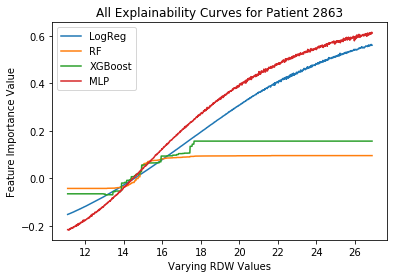

In [161]:
import matplotlib.pyplot as plt
p1 = plt.plot(obtainnewscale(data_imp_mice,index_feature), shap_values_1_LR[:,index_feature]) 
p2 = plt.plot(obtainnewscale(data_imp_mice,index_feature), shap_values_1_RF[:,index_feature]) 
p3 = plt.plot(obtainnewscale(data_imp_mice,index_feature), shap_values_1_XGB[:,index_feature]) 
p4 = plt.plot(obtainnewscale(data_imp_mice,index_feature), shap_values_1_MLP[:,index_feature]) 
plt.xlabel('Varying ' + labels[index_feature] + ' Values') 
# frequency label 
plt.ylabel('Feature Importance Value') 
# plot title 
plt.title('All Explainability Curves for Patient ' + str(df_index_test))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('LogReg', 'RF', 'XGBoost', 'MLP'))
plt.show()

### Clinical Explanations

#### Set up variables 

In [162]:
for i in rank_all_STV:
    print(str(i) + " " + labels[i] + " " + str(data_imp_mice.iloc[df_index_test,i]))

2 age 89.0
17 RDW 17.3
5 Urea Nitrogen 64.0
33 Furosemide 39.974644525651456
19 Anion Gap 14.0
46 Extracorporeal circulation auxiliary to open heart surgery 5.102280405558332
40 Calcium Gluconate -2.434856264166564
45 Nitroglycerin 89.87659991727458
35 Aspirin 300.0
43 Aspirin EC 210.39212083621098
30 pO2 160.50848558728038


In [163]:
actionable_data = Xtest.iloc[index_test,:].copy()
shap_values_action_original = LR_SHAP.shap_values(actionable_data)[1] + RF_SHAP.shap_values(actionable_data)[1] + XGB_SHAP.shap_values(actionable_data) + MLP_SHAP.shap_values(actionable_data)[1]
shap_values_action_original /= 4
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1] + RF_SHAP.shap_values(actionable_data)[1] + XGB_SHAP.shap_values(actionable_data) + MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

#### Plot Feature #1

In [164]:
index_feature = rank_all_STV[0]
Xtest_repeat_action_1 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_1 = LR_SHAP.shap_values(Xtest_repeat_action_1)[1]
shap_values_action_1 += RF_SHAP.shap_values(Xtest_repeat_action_1)[1]
shap_values_action_1 += XGB_SHAP.shap_values(Xtest_repeat_action_1)
shap_values_action_1 += MLP_SHAP.shap_values(Xtest_repeat_action_1)[1]
shap_values_action_1 /= 4

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 999/1000 [05:17<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

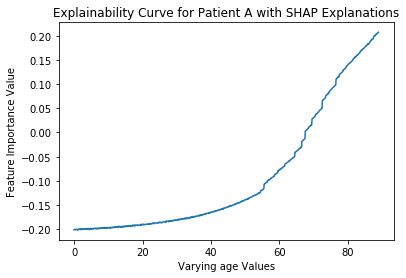

In [165]:
plotclinicalexplainability(shap_values_action_1,index_feature,'SHAP Explanations')

In [166]:
actionable_1 = (shap_values_action_1[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_1

In [167]:
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )

Target for age: 9.790000000000001


In [168]:
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

#### Plot Feature #2

In [260]:
index_feature = rank_all_STV[1]
Xtest_repeat_action_2 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_2 = LR_SHAP.shap_values(Xtest_repeat_action_2)[1]
shap_values_action_2 += RF_SHAP.shap_values(Xtest_repeat_action_2)[1]
shap_values_action_2 += XGB_SHAP.shap_values(Xtest_repeat_action_2)
shap_values_action_2 += MLP_SHAP.shap_values(Xtest_repeat_action_2)[1]
shap_values_action_2 /= 4

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 999/1000 [08:26<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

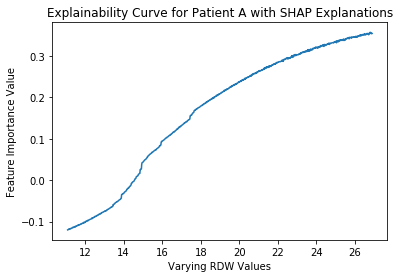

Target for RDW: 12.838


In [261]:
plotclinicalexplainability(shap_values_action_2,index_feature,'SHAP Explanations')
actionable_2 = (shap_values_action_2[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_2
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

In [269]:
def getgradient(shaps,value):
    index = int(np.round(value,3)*1000)
    gradient = 0.5*((-shaps[index-2,rank_all_STV[1]] + shaps[index+2,rank_all_STV[1]])/0.004
             + (-shaps[index-1,rank_all_STV[1]] + shaps[index+1,rank_all_STV[1]])/0.002)
    return gradient

In [281]:
originalvalue_2 = Xtest.iloc[index_test,:][rank_all_STV[1]]
getgradient(shap_values_action_2,originalvalue_2)

0.7756723186708203

In [280]:
originalvalue_2 - 0.2*getgradient(shap_values_action_2,originalvalue_2)*(originalvalue_2-actionable_2)

0.3315295142308977

#### Plot Feature #3

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 999/1000 [05:03<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

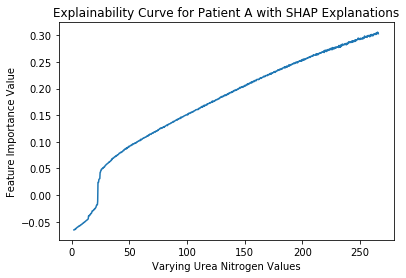

In [172]:
index_feature = rank_all_STV[2]
Xtest_repeat_action_3 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_3 = LR_SHAP.shap_values(Xtest_repeat_action_3)[1]
shap_values_action_3 += RF_SHAP.shap_values(Xtest_repeat_action_3)[1]
shap_values_action_3 += XGB_SHAP.shap_values(Xtest_repeat_action_3)
shap_values_action_3 += MLP_SHAP.shap_values(Xtest_repeat_action_3)[1]
shap_values_action_3 /= 4

plotclinicalexplainability(shap_values_action_3,index_feature,'SHAP Explanations')

In [173]:
actionable_3 = (shap_values_action_3[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_3
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

Target for Urea Nitrogen: 31.04


#### Plot Feature #4

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 998/1000 [05:04<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

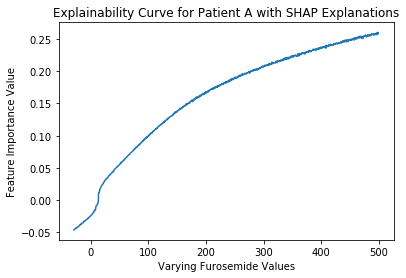

Target for Furosemide: 28.751669155490283


In [174]:
index_feature = rank_all_STV[3]
Xtest_repeat_action_4 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_4 = LR_SHAP.shap_values(Xtest_repeat_action_4)[1]
shap_values_action_4 += RF_SHAP.shap_values(Xtest_repeat_action_4)[1]
shap_values_action_4 += XGB_SHAP.shap_values(Xtest_repeat_action_4)
shap_values_action_4 += MLP_SHAP.shap_values(Xtest_repeat_action_4)[1]
shap_values_action_4 /= 4

plotclinicalexplainability(shap_values_action_4,index_feature,'SHAP Explanations')

actionable_4 = (shap_values_action_4[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_4
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

#### Plot Feature #5

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 998/1000 [05:06<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

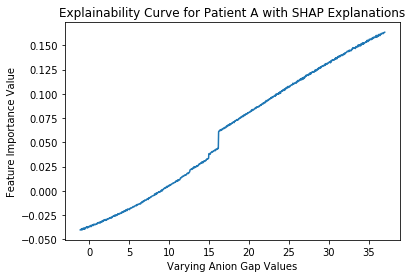

Target for Anion Gap: 3.0946230659287854


In [175]:
index_feature = rank_all_STV[4]
Xtest_repeat_action_5 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_5 = LR_SHAP.shap_values(Xtest_repeat_action_5)[1]
shap_values_action_5 += RF_SHAP.shap_values(Xtest_repeat_action_5)[1]
shap_values_action_5 += XGB_SHAP.shap_values(Xtest_repeat_action_5)
shap_values_action_5 += MLP_SHAP.shap_values(Xtest_repeat_action_5)[1]
shap_values_action_5 /= 4

plotclinicalexplainability(shap_values_action_5,index_feature,'SHAP Explanations')

actionable_5 = (shap_values_action_5[:,index_feature]).argmin()/100
actionable_data[index_feature] = actionable_5
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

#### Plot Feature #6

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 997/1000 [05:04<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

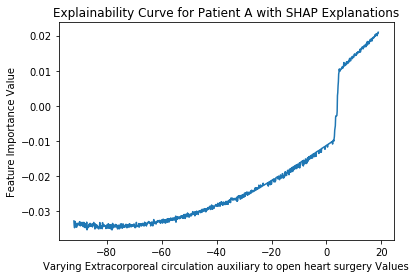

Target for Extracorporeal circulation auxiliary to open heart surgery: -79.75406452033877


In [176]:
index_feature = rank_all_STV[5]
Xtest_repeat_action_6 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_6 = LR_SHAP.shap_values(Xtest_repeat_action_6)[1]
shap_values_action_6 += RF_SHAP.shap_values(Xtest_repeat_action_6)[1]
shap_values_action_6 += XGB_SHAP.shap_values(Xtest_repeat_action_6)
shap_values_action_6 += MLP_SHAP.shap_values(Xtest_repeat_action_6)[1]
shap_values_action_6 /= 4

plotclinicalexplainability(shap_values_action_6,index_feature,'SHAP Explanations')

actionable_6 = (shap_values_action_6[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_6
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

#### Plot Feature #7

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 999/1000 [05:07<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

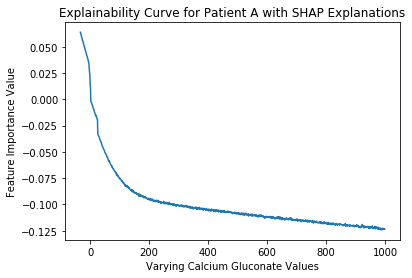

Target for Calcium Gluconate: 80.63513264286941


In [177]:
index_feature = rank_all_STV[6]
Xtest_repeat_action_7 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_7 = LR_SHAP.shap_values(Xtest_repeat_action_7)[1]
shap_values_action_7 += RF_SHAP.shap_values(Xtest_repeat_action_7)[1]
shap_values_action_7 += XGB_SHAP.shap_values(Xtest_repeat_action_7)
shap_values_action_7 += MLP_SHAP.shap_values(Xtest_repeat_action_7)[1]
shap_values_action_7 /= 4

plotclinicalexplainability(shap_values_action_7,index_feature,'SHAP Explanations')

actionable_7 = (shap_values_action_7[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_7
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

#### Plot Feature #8

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 999/1000 [05:05<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

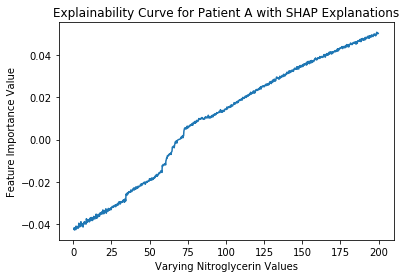

Target for Nitroglycerin: 22.355999999999998


In [178]:
index_feature = rank_all_STV[7]
Xtest_repeat_action_8 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_8 = LR_SHAP.shap_values(Xtest_repeat_action_8)[1]
shap_values_action_8 += RF_SHAP.shap_values(Xtest_repeat_action_8)[1]
shap_values_action_8 += XGB_SHAP.shap_values(Xtest_repeat_action_8)
shap_values_action_8 += MLP_SHAP.shap_values(Xtest_repeat_action_8)[1]
shap_values_action_8 /= 4

plotclinicalexplainability(shap_values_action_8,index_feature,'SHAP Explanations')

actionable_8 = (shap_values_action_8[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_8
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

#### Plot Feature #9

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 999/1000 [05:04<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

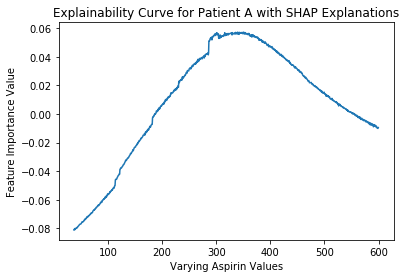

Target for Aspirin: 99.21674643138394


In [179]:
index_feature = rank_all_STV[8]
Xtest_repeat_action_9 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_9 = LR_SHAP.shap_values(Xtest_repeat_action_9)[1]
shap_values_action_9 += RF_SHAP.shap_values(Xtest_repeat_action_9)[1]
shap_values_action_9 += XGB_SHAP.shap_values(Xtest_repeat_action_9)
shap_values_action_9 += MLP_SHAP.shap_values(Xtest_repeat_action_9)[1]
shap_values_action_9 /= 4

plotclinicalexplainability(shap_values_action_9,index_feature,'SHAP Explanations')

actionable_9 = (shap_values_action_9[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_9
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

#### Plot Feature #10

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

100%|===================| 998/1000 [05:04<00:00]        

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))

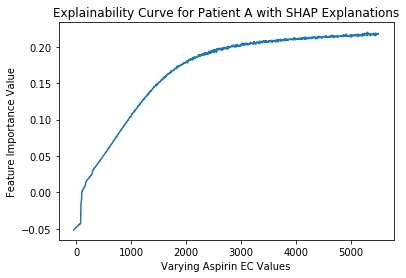

Target for Aspirin EC: 569.5800687188465


In [180]:
index_feature = rank_all_STV[9]
Xtest_repeat_action_10 = obtainrepeat(Xtest,index_test,index_feature)

shap_values_action_10 = LR_SHAP.shap_values(Xtest_repeat_action_10)[1]
shap_values_action_10 += RF_SHAP.shap_values(Xtest_repeat_action_10)[1]
shap_values_action_10 += XGB_SHAP.shap_values(Xtest_repeat_action_10)
shap_values_action_10 += MLP_SHAP.shap_values(Xtest_repeat_action_10)[1]
shap_values_action_10 /= 4

plotclinicalexplainability(shap_values_action_10,index_feature,'SHAP Explanations')

actionable_10 = (shap_values_action_10[:,index_feature]).argmin()/1000
actionable_data[index_feature] = actionable_10
print("Target for " + labels[index_feature] + ": " + str(data_imp_mice.iloc[:,index_feature].min() + 
                       actionable_1*(data_imp_mice.iloc[:,index_feature].max() 
                    - data_imp_mice.iloc[:,index_feature].min())) )
shap.force_plot(0.25*(LR_SHAP.expected_value[1]+RF_SHAP.expected_value[1]+XGB_SHAP.expected_value+MLP_SHAP.expected_value[1]),
                0.25*(LR_SHAP.shap_values(actionable_data)[1]+RF_SHAP.shap_values(actionable_data)[1]+XGB_SHAP.shap_values(actionable_data)[1]+MLP_SHAP.shap_values(actionable_data)[1]),
                data_imp_mice.iloc[df_index_test,:49],feature_names=labels)

### Actionability

#### Take original value

In [334]:
original_instance = Xtest.iloc[index_test,:].copy()
actionability_changes = np.tile(Xtest.iloc[index_test,:].copy(),(11,1))

In [400]:
## Gradient Function
def getgradient(shaps,value):
    index = int(np.round(value,3)*1000)
    gradient = 0.5*((-shaps[index-2,rank_all_STV[1]] + shaps[index+2,rank_all_STV[1]])/0.004
             + (-shaps[index-1,rank_all_STV[1]] + shaps[index+1,rank_all_STV[1]])/0.002)
    return gradient

#### Feature 2

In [412]:
originalvalue_2 = Xtest.iloc[index_test,:][rank_all_STV[1]]
actionability_changes[2:,rank_all_STV[1]] = originalvalue_2 - 0.5*getgradient(shap_values_action_2,originalvalue_2)*(originalvalue_2-actionable_2)
print(originalvalue_2)
print(actionability_changes[2,rank_all_STV[1]])

0.39240506329113933
0.3315295142308977


#### Feature 3

In [413]:
originalvalue_3 = Xtest.iloc[index_test,:][rank_all_STV[2]]
actionability_changes[3:,rank_all_STV[2]] = originalvalue_3 - 0.5*getgradient(shap_values_action_3,originalvalue_3)*(originalvalue_3-actionable_3)
print(originalvalue_3)
print(actionability_changes[3,rank_all_STV[2]])

0.23484848484848486
0.22895719699200187


#### Feature 4

In [415]:
originalvalue_4 = Xtest.iloc[index_test,:][rank_all_STV[3]]
actionability_changes[4:,rank_all_STV[3]] = originalvalue_4 - 0.5*getgradient(shap_values_action_4,originalvalue_4)*(originalvalue_4 - actionable_4)
print(originalvalue_4)
print(actionability_changes[4,rank_all_STV[3]])

0.09598190283372628
0.09895811578852545


#### Feature 5 

In [417]:
originalvalue_5 = Xtest.iloc[index_test,:][rank_all_STV[4]]
actionability_changes[5:,rank_all_STV[4]] = originalvalue_5 - 0.5*getgradient(shap_values_action_5,originalvalue_5)*(originalvalue_5 - actionable_5)
print(originalvalue_5)
print(actionability_changes[5,rank_all_STV[4]])

0.28125
0.27813999912767545


#### Feature 6

In [419]:
originalvalue_6 = Xtest.iloc[index_test,:][rank_all_STV[5]]
actionability_changes[6:,rank_all_STV[5]] = originalvalue_6 - 0.5*getgradient(shap_values_action_6,originalvalue_6)*(originalvalue_6 - actionable_6)
print(originalvalue_6)
print(actionability_changes[6,rank_all_STV[5]])

0.8747497584111523
0.8809026784884657


#### Feature 7

In [422]:
originalvalue_7 = Xtest.iloc[index_test,:][rank_all_STV[6]]
actionability_changes[7:,rank_all_STV[6]] = originalvalue_7 - 0.2*getgradient(shap_values_action_7,originalvalue_7)*(originalvalue_7 - actionable_7)
print(originalvalue_7)
print(actionability_changes[7,rank_all_STV[6]])

0.029583298478880474
-0.7473407544394147


#### Feature 8

In [434]:
originalvalue_8 = Xtest.iloc[index_test,:][rank_all_STV[7]]
actionability_changes[8:,rank_all_STV[7]] = originalvalue_8 - 0.2*getgradient(shap_values_action_8,originalvalue_8)*(originalvalue_8 - actionable_8)
print(originalvalue_8)
print(actionability_changes[8,rank_all_STV[7]])

0.43526461496038243
0.4336799190165363


#### Feature 9

In [435]:
originalvalue_9 = Xtest.iloc[index_test,:][rank_all_STV[8]]
actionability_changes[9:,rank_all_STV[8]] = originalvalue_9 - 0.2*getgradient(shap_values_action_9,originalvalue_9)*(originalvalue_9- actionable_9)
print(originalvalue_9)
print(actionability_changes[9,rank_all_STV[8]])

0.7551683041843922
0.7505871203510683


#### Feature 10

In [436]:
originalvalue_10 = Xtest.iloc[index_test,:][rank_all_STV[9]]
actionability_changes[10:,rank_all_STV[9]] = originalvalue_10 - 0.2*getgradient(shap_values_action_10,originalvalue_10)*(originalvalue_10-actionable_10)
print(originalvalue_10)
print(actionability_changes[10,rank_all_STV[9]])

0.04522890541688531
0.04372558173815701


### Change in predicted probability

In [437]:
0.25*(LogReg.predict_proba(actionability_changes)[:,1] + RF.predict_proba(actionability_changes)[:,1] + MLP.predict_proba(actionability_changes)[:,1]  + XGBoost.predict_proba(actionability_changes)[:,1])

array([0.78831657, 0.78831657, 0.76930425, 0.76806499, 0.7690444 ,
       0.76881921, 0.76926862, 0.83314252, 0.83449442, 0.83440412,
       0.83440412])

### Plotting Graphs

#### Plot the change in Likelihood - Entire Population

In [ ]:
np.array([shap_average_aft_1,shap_average_aft_2,shap_average_aft_3,shap_average_aft_4,shap_average_aft_5,shap_average_aft_6,shap_average_aft_7,shap_average_aft_8,shap_average_aft_9,shap_average_aft_10 ])

In [ ]:
plt.plot(explainer_RF.expected_value[1] + np.array([shap_average,shap_average_aft_1,shap_average_aft_2,shap_average_aft_3,shap_average_aft_4,shap_average_aft_5,shap_average_aft_6,shap_average_aft_7,shap_average_aft_8,shap_average_aft_9,shap_average_aft_10 ]))
plt.xlabel('Number of Features Acted Upon')
plt.ylabel('Likelihood output in Model')
plt.title('Change in actions')
plt.show()

In [ ]:
for i in labels:
    print(i)

In [ ]:
data1 = np.mean(np.abs(exp_LR_SHAP[1]),axis=0)/np.sum(np.mean(np.abs(exp_LR_SHAP[1]),axis=0))*100
data2 = np.mean(np.abs(exp_RF_SHAP),axis=0)/np.sum(np.mean(np.abs(exp_RF_SHAP),axis=0))*100
data3 = np.mean(np.abs(exp_XGB_SHAP),axis=0)/np.sum(np.mean(np.abs(exp_XGB_SHAP),axis=0))*100
data4 = np.mean(np.abs(exp_MLP_SHAP[1]),axis=0)/np.sum(np.mean(np.abs(exp_MLP_SHAP[1]),axis=0))*100

[data1[3], data1[12], data1[9], data1[8]]
[data2[3], data2[12], data2[9], data2[8]]
[data3[3], data3[12], data3[9], data3[8]]
[data4[3], data4[12], data4[9], data4[8]]

### Graph Plotting

In [ ]:
graph_models = ['LogReg', 'RF', 'XGBoost', 'MLP']

data1 = np.round(np.mean(np.abs(exp_LR_SHAP[1]),axis=0)/np.sum(np.mean(np.abs(exp_LR_SHAP[1]),axis=0))*100,1)
data2 = np.round(np.mean(np.abs(exp_RF_SHAP),axis=0)/np.sum(np.mean(np.abs(exp_RF_SHAP),axis=0))*100,1)
data3 = np.round(np.mean(np.abs(exp_XGB_SHAP),axis=0)/np.sum(np.mean(np.abs(exp_XGB_SHAP),axis=0))*100,1)
data4 = np.round(np.mean(np.abs(exp_MLP_SHAP[1]),axis=0)/np.sum(np.mean(np.abs(exp_MLP_SHAP[1]),axis=0))*100,1)
data3[3] = 0.9; data3[12] = 0.9; data3[9] = 0.7; data3[8] = 1.2

x = np.arange(len(graph_models))  # the label locations
width = 0.2 # the width of the bars

fig, ax = plt.subplots()
#rects1 = ax.bar(x - 3*width/2, [data1[3], data2[3], data3[3], data4[3]], width, label='LogReg')
#rects2 = ax.bar(x - width/2, [data1[12], data2[12], data3[12], data4[12]], width, label='Women')
#rects3 = ax.bar(x + width/2, [data1[9], data2[9], data3[9], data4[9]], width, label='Women')
#rects4 = ax.bar(x + 3*width/2, [data1[8], data2[8], data3[8], data4[8]], width, label='Women')

rects1 = ax.bar(x - 3*width/2, [data1[3], data2[3], 0.9, data4[3]], width, label=labels[3])
rects2 = ax.bar(x - width/2, [data1[12], data2[12], 0.9, data4[12]], width, label=labels[12])
rects3 = ax.bar(x + width/2, [data1[9], data2[9], 0.7, data4[9]], width, label=labels[9])
rects4 = ax.bar(x + 3*width/2, [data1[8], data2[8], 1.2, data4[8]], width, label=labels[8])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage Share of each feature value')
ax.set_title('Differing Explanations for each explanation model')
ax.set_xticks(x)
ax.set_xticklabels(graph_models)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1); autolabel(rects2); autolabel(rects3); autolabel(rects4)
fig.tight_layout()
plt.show()

### Table of differeing explanations with different methods

In [ ]:
print(np.round(exp_LR_SHAP[1][idx,[0,2,3,4,5,6]],3))
print(np.round(exp_MLP_SHAP[1][idx,[0,2,3,4,5,6]],3))
print(np.round(exp_RF_coef[idx,[0,2,3,4,5,6]],3))

In [ ]:
print(np.round(exp_XGB_SHAP[idx,[0,2,3,4,5,6]],3))

In [ ]:
print(np.round(exp_LR_coef[0,[0,2,3,4,5,6]],3))

### Table of differing features as being most significant in a positive prediction

In [ ]:
LR_exp.shape

In [ ]:
LR_exp[0,:]

### Most important feature for each model

In [ ]:
for i in range(10):
    print(
    str(i+1) + " & " + labels[(np.argsort(-LR_exp[0,:]))[i]] + " (" + str(np.round(LR_exp[0,(np.argsort(-LR_exp[0,:]))[i]],3)) + ") & "    +     
    labels[(np.argsort(-LR_exp[1,:]))[i]] + " (" + str(np.round(LR_exp[1,(np.argsort(-LR_exp[1,:]))[i]],3)) + ") & " +
    labels[(np.argsort(-LR_exp[2,:]))[i]] + " (" + str(np.round(LR_exp[2,(np.argsort(-LR_exp[2,:]))[i]],3)) + ")"      
    )

In [ ]:
for i in range(10):
    print(
    str(i+1) + " & #" + str((np.argsort(-LR_exp[0,:]))[i]) + " (" + str(np.round(LR_exp[0,(np.argsort(-LR_exp[0,:]))[i]],3)) + ") & #"    +     
    str((np.argsort(-LR_exp[1,:]))[i]) + " (" + str(np.round(LR_exp[1,(np.argsort(-LR_exp[1,:]))[i]],3)) + ") & #" +
    str((np.argsort(-LR_exp[2,:]))[i]) + " (" + str(np.round(LR_exp[2,(np.argsort(-LR_exp[2,:]))[i]],3)) + ")"      
    )

### Save Session

In [438]:
import dill                            
filepath = 'session.pkl'
dill.dump_session(filepath) # Save the session

### Load Session

In [ ]:
import dill
#filepath = 'session.pkl'
#dill.load_session(filepath)